# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [3]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/Ivy.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
     
graph_df['Bug'] = graph_df.Bug.astype('int')
    
x = graph_df["Name"]
y = graph_df["Bug"]

In [4]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Jaikiran Pai,test/java/org/apache/ivy/plugins/parser/m2/tes...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,-0.088973,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
1,Jaikiran Pai,test/java/org/apache/ivy/plugins/parser/m2/tes...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,-0.088973,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
2,Jaikiran Pai,test/java/org/apache/ivy/plugins/parser/m2/tes...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,-0.088973,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
3,Jaikiran Pai,test/java/org/apache/ivy/plugins/parser/m2/Pom...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,-0.088973,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
4,Jaikiran Pai,src/java/org/apache/ivy/plugins/parser/m2/PomM...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,-0.088973,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24452,mb,src/example/build-a-ivy-repository/build.xml,0,0.160488,0.000000,0.540984,0.575758,18.0,10,0.111134,...,-0.603079,-0.115309,-0.198618,0.645886,0.350747,0.300233,0.730288,0.187819,-0.359123,-0.857817
24453,mb,src/example/build-a-ivy-repository/config/ivy-...,0,0.160488,0.000000,0.540984,0.575758,18.0,10,0.111134,...,-0.603079,-0.115309,-0.198618,0.645886,0.350747,0.300233,0.730288,0.187819,-0.359123,-0.857817
24454,mb,src/example/build-a-ivy-repository/config/ivy-...,0,0.160488,0.000000,0.540984,0.575758,18.0,10,0.111134,...,-0.603079,-0.115309,-0.198618,0.645886,0.350747,0.300233,0.730288,0.187819,-0.359123,-0.857817
24455,mb,src/java/fr/jayasoft/ivy/resolver/IBiblioResol...,0,0.160488,0.000000,0.540984,0.575758,18.0,10,0.111134,...,-0.603079,-0.115309,-0.198618,0.645886,0.350747,0.300233,0.730288,0.187819,-0.359123,-0.857817


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [5]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    15835
1     8622
Name: Bug, dtype: int64


Creating models...

In [6]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [7]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [8]:
print(train['Bug'].value_counts())
train

0    11093
1     6026
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,24195,Xavier Hanin,src/java/org/apache/ivy/plugins/parser/ModuleD...,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
1,9620,twogee,src/java/org/apache/ivy/osgi/repo/RepositoryMa...,0,3.025280,25.081798,0.970588,0.984848,9360.0,10,...,-0.111155,0.833962,-0.333011,-0.243763,-0.320643,-0.662272,-0.737100,-0.840559,-0.594730,-0.123380
2,13920,Xavier Hanin,test/repositories/1/org2/mod2.1/ivys/ivy-0.3.1...,0,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
3,17345,Xavier Hanin,test/repositories/latest-compatible/C/2.6/ivy.xml,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
4,5144,jkf,test/java/org/apache/ivy/plugins/parser/xml/te...,0,3.633973,19.848642,0.942857,0.969697,6032.0,10,...,0.342548,0.678380,-0.753433,0.202530,0.758757,-0.536205,-0.392351,0.031651,-0.117102,-0.596495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,23670,Xavier Hanin,test/repositories/IVY-283/module_b/ivy-local.xml,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
17115,3046,Maarten Coene,doc/settings/namespaces.html,0,2.409521,113.145817,0.970588,0.984848,14569.0,10,...,-0.182774,0.517100,-0.082632,-0.574056,-0.395730,0.236050,0.226718,-0.077750,-0.442182,-0.479539
17116,20463,Xavier Hanin,src/java/fr/jayasoft/ivy/url/HttpClientHandler...,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
17117,18638,Xavier Hanin,src/java/org/apache/ivy/ant/IvyBuildNumber.java,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [9]:
print(test['Bug'].value_counts())
test

0    4742
1    2596
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,6009,jkf,src/java/org/apache/ivy/core/cache/RepositoryC...,0,3.633973,19.848642,0.942857,0.969697,6032.0,10,...,0.342548,0.678380,-0.753433,0.202530,0.758757,-0.536205,-0.392351,0.031651,-0.117102,-0.596495
1,20859,Xavier Hanin,doc/doc/ivyfile/mapped.html,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
2,21493,Xavier Hanin,src/java/org/apache/ivy/Artifact.java,1,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217
3,6224,jkf,asciidoc/standalone.adoc,0,3.633973,19.848642,0.942857,0.969697,6032.0,10,...,0.342548,0.678380,-0.753433,0.202530,0.758757,-0.536205,-0.392351,0.031651,-0.117102,-0.596495
4,1618,Jaikiran Pai,doc/images/ivy-terminology.odg,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,1654,Jaikiran Pai,doc/configuration/property.html,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
7334,5337,jkf,test/java/org/apache/ivy/core/settings/ivysett...,0,3.633973,19.848642,0.942857,0.969697,6032.0,10,...,0.342548,0.678380,-0.753433,0.202530,0.758757,-0.536205,-0.392351,0.031651,-0.117102,-0.596495
7335,8,Jaikiran Pai,src/java/org/apache/ivy/plugins/parser/xml/Xml...,0,3.236756,76.573395,0.970588,0.984848,8092.0,10,...,0.081424,-0.314755,-0.586661,0.313876,-0.093442,0.103162,-0.158147,-0.441086,-0.109884,-0.074599
7336,16351,Xavier Hanin,doc/use/makepom.html,0,2.938383,54.644806,0.942857,0.969697,30615.0,10,...,-0.232121,0.448012,0.336253,0.125690,-0.604751,0.897813,0.745579,0.680642,0.632146,-0.685217


In [10]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.8540474243663123
Logistic regression training score for model 2: 0.8547288089397655
Random Forrest Classification training score for model 1: 0.8547288089397655
Random Forrest Classification training score for model 2: 0.8547288089397655
XGB Classifier training score for model 1: 0.8547288089397655
XGB Classifier training score for model 2: 0.8547288089397655


Compare model scores for Logistic Regression

In [11]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.8893428247331164
Average Precision-Recall Score: 0.7227870872934735
PRC-AUC for model 1: 0.8473007397150175
Accuracy: 0.854
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4742
           1       0.73      0.92      0.82      2596

    accuracy                           0.85      7338
   macro avg       0.84      0.87      0.85      7338
weighted avg       0.87      0.85      0.86      7338


Scores for model 2
------------------
Roc_Auc Score: 0.8933941699880229
Average Precision-Recall Score: 0.7265152073325243
PRC-AUC for model 2: 0.8506669814924808
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4742
           1       0.73      0.92      0.82      2596

    accuracy      

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.227449, F1-Score=0.818 for model 1
Best Threshold=0.719065, F1-Score=0.818 for model 2


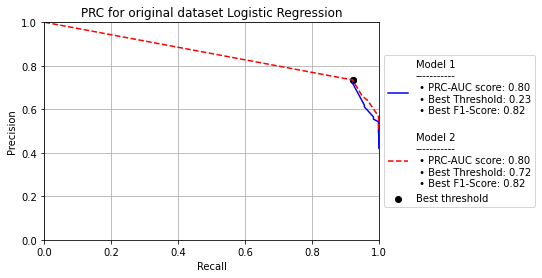

In [12]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.718705, F1-Score=0.818 for model 1
Best Threshold=0.718769, F1-Score=0.818 for model 2


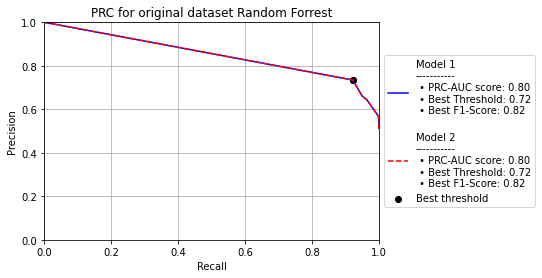

In [13]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.719089, F1-Score=0.818 for model 1
Best Threshold=0.719090, F1-Score=0.818 for model 2


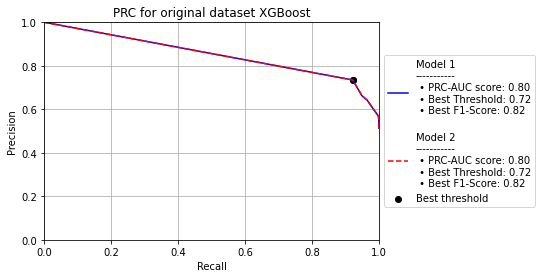

In [14]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

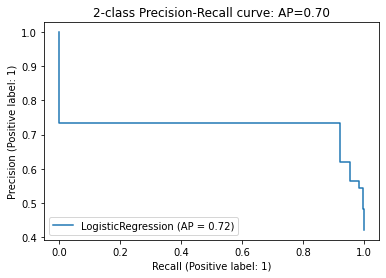

In [15]:
simple_threshold_plot(lr_model1, x1_test, y_test)

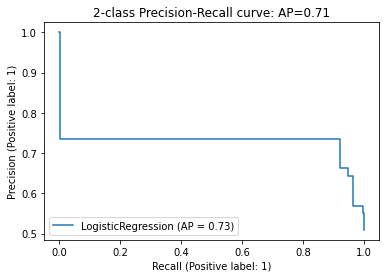

In [16]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [17]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf_model1.score(x1_test, y_test)
results_data[4][2] = rf_model2.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb_model1.score(x1_test, y_test)
results_data[5][2] = xgb_model2.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.8893428247331164
Average Precision-Recall Score: 0.7227870872934735
PRC-AUC for model 1: 0.7994798609146874
Accuracy: 0.854
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4742
           1       0.73      0.92      0.82      2596

    accuracy                           0.85      7338
   macro avg       0.84      0.87      0.85      7338
weighted avg       0.87      0.85      0.86      7338


Scores for model 2
------------------
Roc_Auc Score: 0.8933941699880229
Average Precision-Recall Score: 0.7265152073325243
PRC-AUC for model 2: 0.8000496535020805
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4742
           1       0.73      0.92      0.82      2596

    accuracy                           0.85      7338
   macro avg       0.84      0.87      0.85      7338
weighted 

### Cross Validation

In [18]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [19]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.91978413 1.         0.62524534]

Cross validation results for model 2
------------------------------------
[0.91978413 0.85929833 0.40309127]


#### Model 1 Cross Validation

#### Leave One Out

In [20]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [21]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, x1, y)
results_data[6][0] = "Original_Logistic_Regression_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, x1, y)
results_data[8][0] = "Original_Random_Forrest_rkf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, x1, y)
results_data[9][0] = "Original_XGB_Classifier_rkf"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 24453 24454 24455] | TEST: [   29    30    34 ... 24411 24440 24456]

Model Score: 0.8618152085036794
Average Precision-Recall Score: 0.7222616241860664
PRC-AUC Score: 0.8128167272382363
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1559
           1       0.75      0.93      0.83       887

    accuracy                           0.86      2446
   macro avg       0.85      0.88      0.86      2446
weighted avg       0.88      0.86      0.86      2446

Accuracy: 0.862
---------------------
With best threshold
TRAIN: [    0     1     2 ... 24453 24454 24455] | TEST: [   29    30    34 ... 24411 24440 24456]

Model Score: 0.8618152085036794
Average Precision-Recall Score: 0.7222616241860664
PRC-AUC Score: 0.8116545815595846
Classification Report:

            

#### Stratified KFold

In [22]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, x1, y)
results_data[10][0] = "Original_Logistic_Regression_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, x1, y, lr_best_threshold1)
results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, x1, y)
results_data[12][0] = "Original_Random_Forrest_skf"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, x1, y)
results_data[13][0] = "Original_XGB_Classifier_skf"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 24454 24455 24456] | TEST: [ 1584  1585  1586 ... 17543 17544 17545]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      1.00      1.00       862

    accuracy                           1.00      2446
   macro avg       1.00      1.00      1.00      2446
weighted avg       1.00      1.00      1.00      2446

Accuracy: 1.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 24454 24455 24456] | TEST: [ 1584  1585  1586 ... 17543 17544 17545]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.6983433041877589
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1

#### Time Series Split

In [23]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, x1, y)
results_data[14][0] = "Original_Logistic_Regression_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, x1, y, lr_best_threshold1)
results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, x1, y)
results_data[16][0] = "Original_Random_Forrest_tss"
results_data[16][1] = model_score
results_data[16][3] = acc
results_data[16][5] = prc_val
results_data[16][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, x1, y)
results_data[17][0] = "Original_XGB_Classifier_tss"
results_data[17][1] = model_score
results_data[17][3] = acc
results_data[17][5] = prc_val
results_data[17][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 20378 20379 20380] | TEST: [20381 20382 20383 ... 24454 24455 24456]

Model Score: 0.9950932286555446

Average Precision-Recall Score: 0.9999843002639729
PRC-AUC Score: 0.9999860494390779
Classification Report:

              precision    recall  f1-score   support

           0       0.39      1.00      0.57        13
           1       1.00      1.00      1.00      4063

    accuracy                           1.00      4076
   macro avg       0.70      1.00      0.78      4076
weighted avg       1.00      1.00      1.00      4076

Accuracy: 0.995
---------------------
With best threshold
TRAIN: [    0     1     2 ... 20378 20379 20380] | TEST: [20381 20382 20383 ... 24454 24455 24456]

Model Score: 0.9950932286555446

Average Precision-Recall Score: 0.9999843002639729
PRC-AUC Score: 0.9985147667447661
Classification Report:

          

#### Model 2 Cross Validation

#### Leave One Out

In [24]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [25]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, x2, y, lr_best_threshold2)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, x2, y)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 24453 24454 24455] | TEST: [   29    30    34 ... 24411 24440 24456]

Model Score: 0.8622240392477515
Average Precision-Recall Score: 0.7229099193869086
PRC-AUC Score: 0.6589853849265754
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1559
           1       0.75      0.93      0.83       887

    accuracy                           0.86      2446
   macro avg       0.85      0.88      0.86      2446
weighted avg       0.88      0.86      0.86      2446

Accuracy: 0.862
---------------------
With best threshold
TRAIN: [    0     1     2 ... 24453 24454 24455] | TEST: [   29    30    34 ... 24411 24440 24456]

Model Score: 0.8622240392477515
Average Precision-Recall Score: 0.7229099193869086
PRC-AUC Score: 0.8130638262044549
Classification Report:

            

#### Stratified KFold

In [26]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, x2, y, lr_best_threshold2)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, x2, y)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 24454 24455 24456] | TEST: [ 1584  1585  1586 ... 17543 17544 17545]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      1.00      1.00       862

    accuracy                           1.00      2446
   macro avg       1.00      1.00      1.00      2446
weighted avg       1.00      1.00      1.00      2446

Accuracy: 1.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 24454 24455 24456] | TEST: [ 1584  1585  1586 ... 17543 17544 17545]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.6762060506950123
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1

#### Time Series Split

In [27]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, x2, y, lr_best_threshold2)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, x2, y)
results_data[16][2] = model_score
results_data[16][4] = acc
results_data[16][6] = prc_val
results_data[16][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, x2, y)
results_data[17][2] = model_score
results_data[17][4] = acc
results_data[17][6] = prc_val
results_data[17][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 20378 20379 20380] | TEST: [20381 20382 20383 ... 24454 24455 24456]

Model Score: 0.9950932286555446

Average Precision-Recall Score: 0.9999843002639729
PRC-AUC Score: 0.9992611141815106
Classification Report:

              precision    recall  f1-score   support

           0       0.39      1.00      0.57        13
           1       1.00      1.00      1.00      4063

    accuracy                           1.00      4076
   macro avg       0.70      1.00      0.78      4076
weighted avg       1.00      1.00      1.00      4076

Accuracy: 0.995
---------------------
With best threshold
TRAIN: [    0     1     2 ... 20378 20379 20380] | TEST: [20381 20382 20383 ... 24454 24455 24456]

Model Score: 0.9950932286555446

Average Precision-Recall Score: 0.9999843002639729
PRC-AUC Score: 0.998405299313052
Classification Report:

           

Best Threshold=0.225594, F1-Score=0.830 for model 1
Best Threshold=0.720696, F1-Score=0.830 for model 2


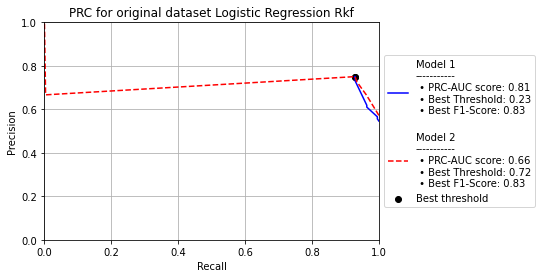

Best Threshold=0.720471, F1-Score=0.830 for model 1
Best Threshold=0.721463, F1-Score=0.830 for model 2


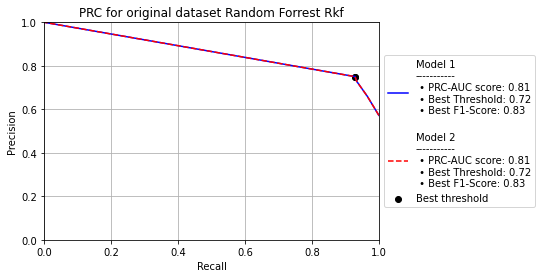

Best Threshold=0.720716, F1-Score=0.830 for model 1
Best Threshold=0.720716, F1-Score=0.830 for model 2


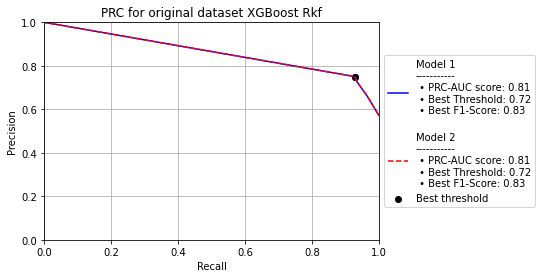

Best Threshold=0.698032, F1-Score=1.000 for model 1
Best Threshold=0.700109, F1-Score=1.000 for model 2


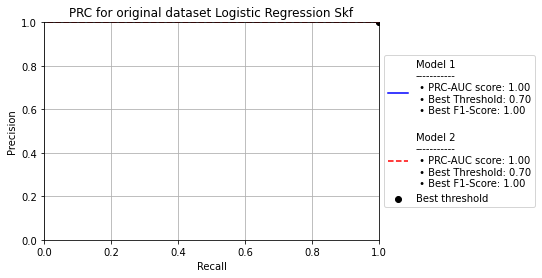

Best Threshold=0.700518, F1-Score=1.000 for model 1
Best Threshold=0.700401, F1-Score=1.000 for model 2


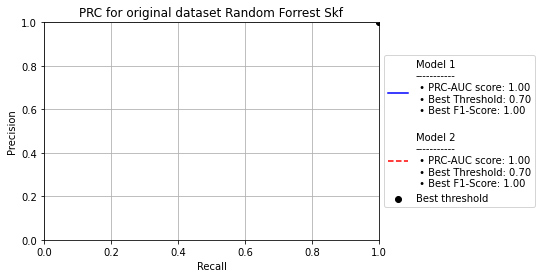

Best Threshold=0.700125, F1-Score=1.000 for model 1
Best Threshold=0.700128, F1-Score=1.000 for model 2


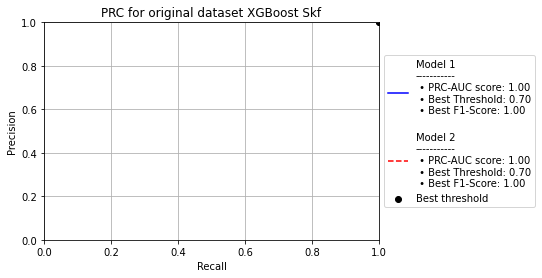

Best Threshold=0.222309, F1-Score=0.998 for model 1
Best Threshold=0.000896, F1-Score=1.000 for model 2


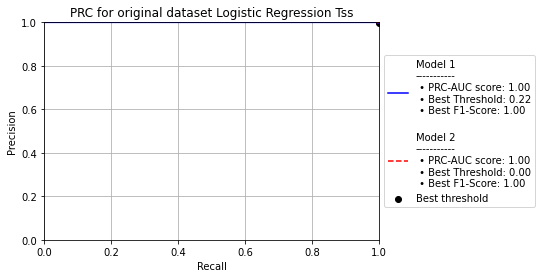

Best Threshold=0.000000, F1-Score=0.998 for model 1
Best Threshold=0.097273, F1-Score=1.000 for model 2


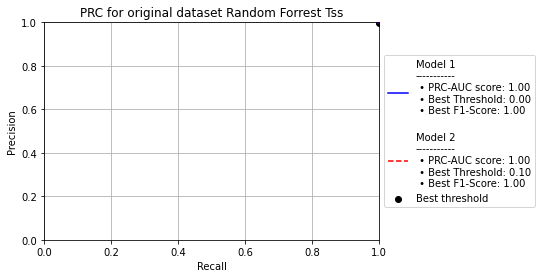

Best Threshold=0.000812, F1-Score=0.998 for model 1
Best Threshold=0.006168, F1-Score=1.000 for model 2


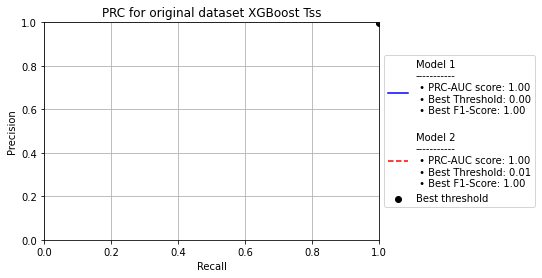

In [28]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

### Rebalancing data

#### Undersampling

In [29]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

0    1900
1    1900
Name: Bug, dtype: int64


In [30]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr_model1.score(x1_test, y_test)
results_data[18][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf_model1.score(x1_test, y_test)
results_data[19][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb_model1.score(x1_test, y_test)
results_data[20][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.856140350877193
Logistic regression training score for model 2: 0.856140350877193
Random Forrest Classification training score for model 1: 0.856140350877193
Random Forrest Classification training score for model 2: 0.856140350877193
XGB Classifier training score for model 1: 0.856140350877193
XGB Classifier training score for model 2: 0.856140350877193


In [31]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.8805519029596806
Average Precision-Recall Score: 0.8065990765982874
PRC-AUC for model 1: 0.8924849444721334
Accuracy: 0.856
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       583
           1       0.82      0.91      0.86       557

    accuracy                           0.86      1140
   macro avg       0.86      0.86      0.86      1140
weighted avg       0.86      0.86      0.86      1140


Scores for model 2
------------------
Roc_Auc Score: 0.8847153490119515
Average Precision-Recall Score: 0.8102583239418328
PRC-AUC for model 2: 0.8939784695291659
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       583
           1       0.82      0.91      0.86       557

    accuracy      

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.837269, F1-Score=0.861 for model 1
Best Threshold=0.840155, F1-Score=0.861 for model 2


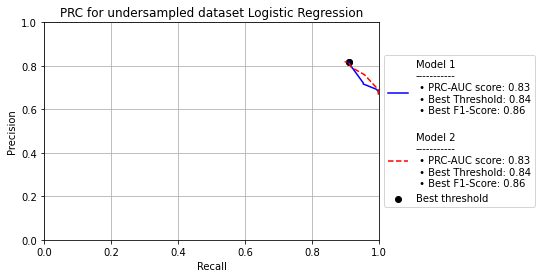

In [32]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.842597, F1-Score=0.861 for model 1
Best Threshold=0.840941, F1-Score=0.861 for model 2


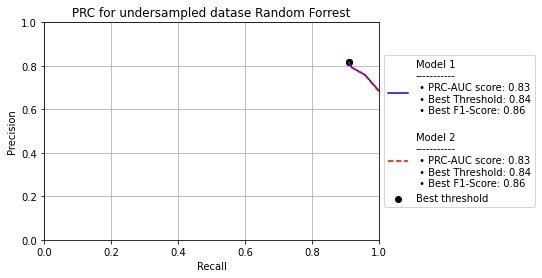

In [33]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.840236, F1-Score=0.861 for model 1
Best Threshold=0.840273, F1-Score=0.861 for model 2


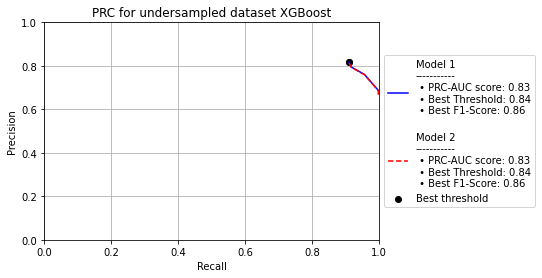

In [34]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

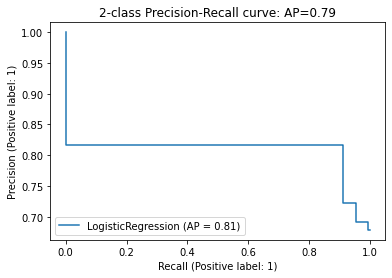

In [35]:
simple_threshold_plot(lr_model1, x1_test, y_test)

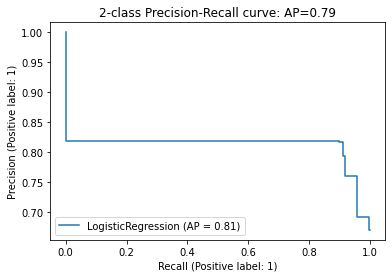

In [36]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [37]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr_model1.score(x1_test, y_test)
results_data[21][2] = lr_model2.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf_model1.score(x1_test, y_test)
results_data[22][2] = rf_model2.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb_model1.score(x1_test, y_test)
results_data[23][2] = xgb_model2.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.8805519029596806
Average Precision-Recall Score: 0.8065990765982874
PRC-AUC for model 1: 0.826685400567221
Accuracy: 0.856
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       583
           1       0.82      0.91      0.86       557

    accuracy                           0.86      1140
   macro avg       0.86      0.86      0.86      1140
weighted avg       0.86      0.86      0.86      1140


Scores for model 2
------------------
Roc_Auc Score: 0.8847153490119515
Average Precision-Recall Score: 0.8102583239418328
PRC-AUC for model 2: 0.826399095930599
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       583
           1       0.82      0.91      0.86       557

    accuracy                           0.86      1140
   macro avg       0.86      0.86      0.86      1140
weighted av

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [38]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_rkf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   1    2    3 ... 3796 3798 3799] | TEST: [   0   29   30   44   61   63   80   88  102  124  152  156  166  173
  175  178  192  194  203  217  218  221  239  247  254  257  274  278
  283  289  295  305  314  324  331  332  346  368  371  376  387  408
  411  416  423  430  433  436  442  449  468  479  495  500  506  534
  549  551  554  557  561  564  573  578  599  602  621  644  650  655
  670  691  700  705  712  720  721  727  755  787  802  805  809  810
  811  816  842  864  879  893  897  915  927  929  948  949  965  976
  978  985 1022 1023 1034 1047 1052 1056 1074 1078 1080 1110 1113 1114
 1116 1117 1123 1128 1146 1149 1164 1174 1187 1188 1226 1228 1231 1251
 1272 1293 1295 1313 1320 1351 1352 1356 1361 1362 1402 1406 1407 1411
 1412 1417 1422 1429 1454 1457 1487 1490 1498 1511 1513 1546 1554 1556
 1572 1582 1583 1588 1593 1602 1612 1620 1621 1

In [39]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_skf"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_skf"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_skf"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1861 1863 1865 1866 1868 1870 1871 1878 1882 1883 1884 1885 1887 1888
 1889 1890 1891 1898 1903 1908 1909 1913 1915 1916 1918 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2

In [40]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, usx1, usy)
results_data[32][0] = "Undersampled_Logistic_Regression_tss"
results_data[32][1] = model_score
results_data[32][3] = acc
results_data[32][5] = prc_val
results_data[32][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[33][1] = model_score
results_data[33][3] = acc
results_data[33][5] = prc_val
results_data[33][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, usx1, usy)
results_data[34][0] = "Undersampled_Random_Forrest_tss"
results_data[34][1] = model_score
results_data[34][3] = acc
results_data[34][5] = prc_val
results_data[34][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, usx1, usy)
results_data[35][0] = "Undersampled_XGB_Classifier_tss"
results_data[35][1] = model_score
results_data[35][3] = acc
results_data[35][5] = prc_val
results_data[35][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

##### Cross Validation After Undersampling Rebalance for model 2

In [41]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3796 3797 3798] | TEST: [  10   15   24   28   54   77   81   94   97  101  107  126  129  131
  136  147  148  164  167  171  181  182  215  236  250  285  310  312
  326  327  329  334  338  341  345  355  362  363  385  390  401  405
  419  428  441  451  454  477  481  513  516  520  545  566  587  592
  609  614  615  628  661  692  701  706  710  711  722  724  726  730
  735  738  745  757  768  774  777  793  799  813  820  822  826  827
  832  848  875  904  909  914  922  934  935  936  938  943  950  951
  966  984  987  989 1002 1013 1039 1040 1046 1086 1107 1111 1112 1120
 1121 1131 1182 1194 1201 1202 1203 1223 1248 1277 1279 1287 1301 1303
 1304 1308 1311 1314 1318 1319 1332 1333 1341 1347 1372 1379 1383 1386
 1387 1394 1401 1430 1449 1466 1471 1481 1508 1521 1523 1524 1561 1599
 1622 1639 1645 1658 1669 1692 1700 1701 1708 1

In [42]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1861 1863 1865 1866 1868 1870 1871 1878 1882 1883 1884 1885 1887 1888
 1889 1890 1891 1898 1903 1908 1909 1913 1915 1916 1918 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2

In [43]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, usx2, usy)
results_data[32][2] = model_score
results_data[32][4] = acc
results_data[32][6] = prc_val
results_data[32][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
results_data[33][2] = model_score
results_data[33][4] = acc
results_data[33][6] = prc_val
results_data[33][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, usx2, usy)
results_data[34][2] = model_score
results_data[34][4] = acc
results_data[34][6] = prc_val
results_data[34][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, usx2, usy)
results_data[35][2] = model_score
results_data[35][4] = acc
results_data[35][6] = prc_val
results_data[35][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

Best Threshold=0.486029, F1-Score=0.692 for model 1
Best Threshold=0.442389, F1-Score=0.702 for model 2


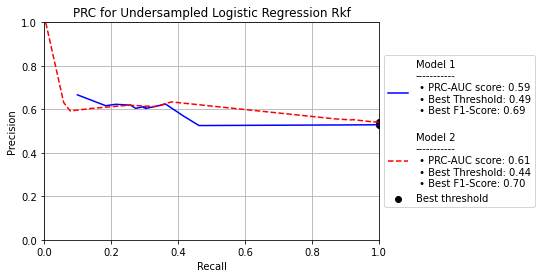

Best Threshold=0.442156, F1-Score=0.702 for model 1
Best Threshold=0.440157, F1-Score=0.702 for model 2


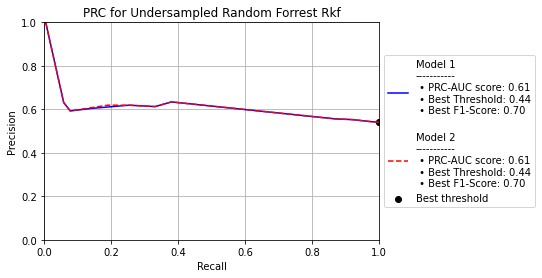

Best Threshold=0.442141, F1-Score=0.702 for model 1
Best Threshold=0.442125, F1-Score=0.702 for model 2


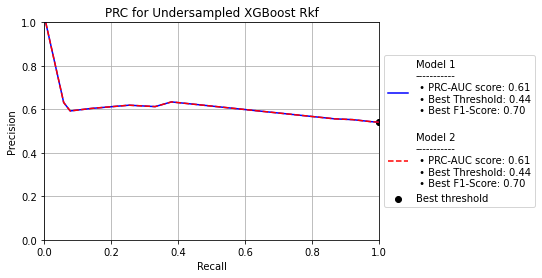

Best Threshold=0.491987, F1-Score=0.667 for model 1
Best Threshold=0.386309, F1-Score=0.667 for model 2


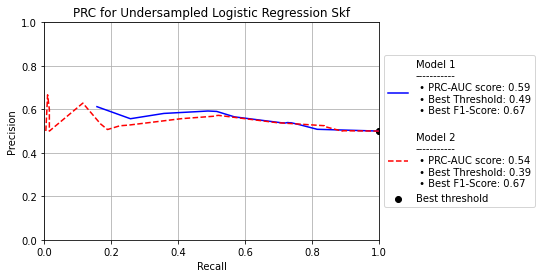

Best Threshold=0.399612, F1-Score=0.667 for model 1
Best Threshold=0.443580, F1-Score=0.667 for model 2


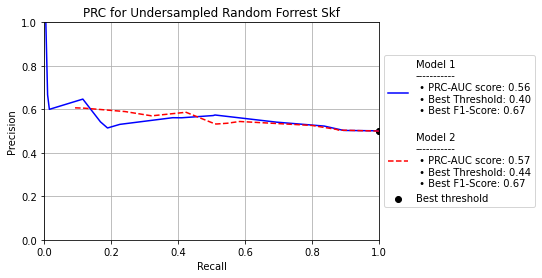

Best Threshold=0.386753, F1-Score=0.667 for model 1
Best Threshold=0.384833, F1-Score=0.667 for model 2


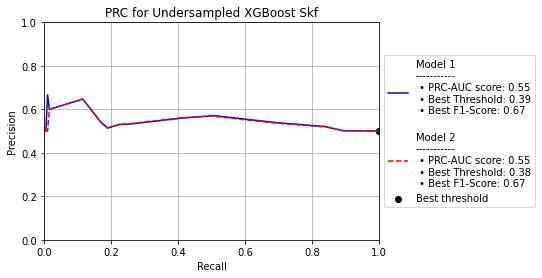

Best Threshold=0.489049, F1-Score=0.678 for model 1
Best Threshold=0.429005, F1-Score=0.678 for model 2


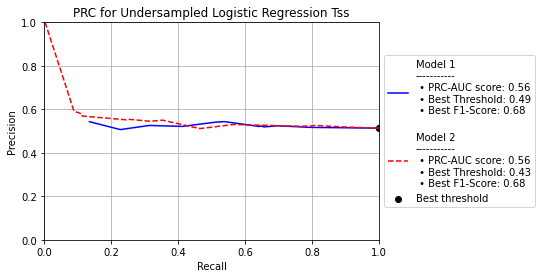

Best Threshold=0.425331, F1-Score=0.678 for model 1
Best Threshold=0.204594, F1-Score=0.673 for model 2


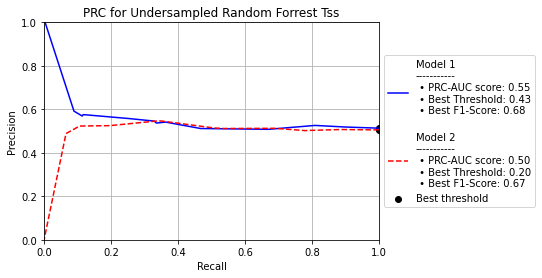

Best Threshold=0.428583, F1-Score=0.678 for model 1
Best Threshold=0.428581, F1-Score=0.678 for model 2


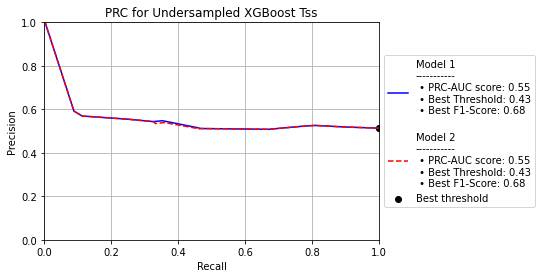

In [44]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Undersampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Undersampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Undersampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Undersampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Undersampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Undersampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Undersampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Undersampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Undersampled XGBoost Tss")

#### Oversampling

In [45]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [46]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(31670, 5)
x2 After SMOTE:
(31670, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [47]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr_model1.score(x1_test, y1_test)
results_data[36][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf_model1.score(x1_test, y1_test)
results_data[37][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb_model1.score(x1_test, y1_test)
results_data[38][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.8689611619829491
Logistic regression training score for model 2: 0.8699084306915061
Random Forrest Classification training score for model 1: 0.8699084306915061
Random Forrest Classification training score for model 2: 0.8699084306915061
XGB Classifier training score for model 1: 0.8699084306915061
XGB Classifier training score for model 2: 0.8699084306915061


In [48]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.8850574936751064
Average Precision-Recall Score: 0.8223290952293668
PRC-AUC for model 1: 0.9012500547622622
Accuracy: 0.869
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4759
           1       0.83      0.92      0.88      4742

    accuracy                           0.87      9501
   macro avg       0.87      0.87      0.87      9501
weighted avg       0.87      0.87      0.87      9501


Scores for model 2
------------------
Roc_Auc Score: 0.8920605181560584
Average Precision-Recall Score: 0.8259716519134621
PRC-AUC for model 2: 0.8632300123352707
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4759
           1       0.83      0.93      0.88      4742

    accuracy      

In [49]:
y1_test.value_counts()

0    4759
1    4742
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.334417, F1-Score=0.876 for model 1
Best Threshold=0.825989, F1-Score=0.877 for model 2


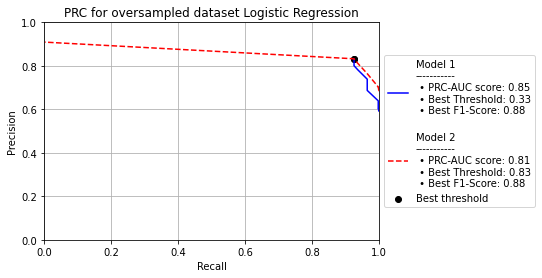

In [50]:
lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.826280, F1-Score=0.877 for model 1
Best Threshold=0.827219, F1-Score=0.877 for model 2


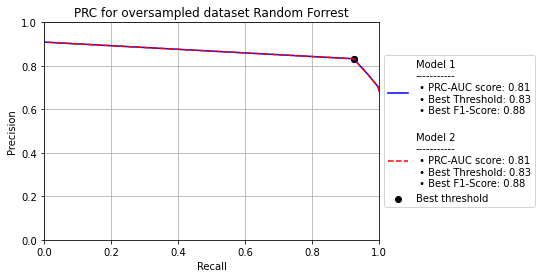

In [51]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.826006, F1-Score=0.877 for model 1
Best Threshold=0.826006, F1-Score=0.877 for model 2


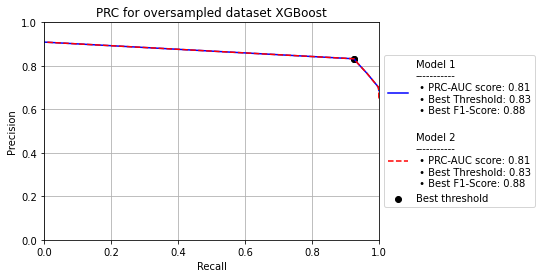

In [52]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

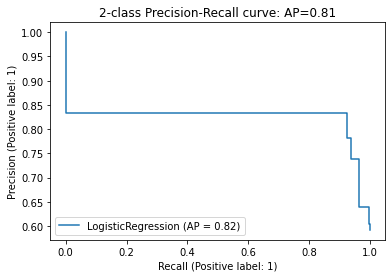

In [53]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

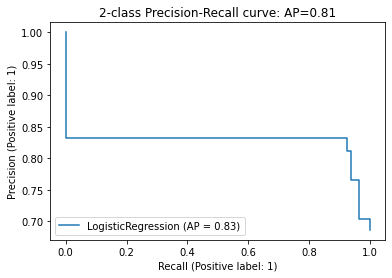

In [54]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [55]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr_model1.score(x1_test, y1_test)
results_data[39][2] = lr_model2.score(x2_test, y2_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf_model1.score(x1_test, y1_test)
results_data[40][2] = rf_model2.score(x2_test, y2_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb_model1.score(x1_test, y1_test)
results_data[41][2] = xgb_model2.score(x2_test, y2_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.8850574936751064
Average Precision-Recall Score: 0.8223290952293668
PRC-AUC for model 1: 0.8479723988874974
Accuracy: 0.870
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4759
           1       0.83      0.93      0.88      4742

    accuracy                           0.87      9501
   macro avg       0.87      0.87      0.87      9501
weighted avg       0.87      0.87      0.87      9501


Scores for model 2
------------------
Roc_Auc Score: 0.8920605181560584
Average Precision-Recall Score: 0.8259716519134621
PRC-AUC for model 2: 0.8061542953262391
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4759
           1       0.83      0.93      0.88      4742

    accuracy                           0.87      9501
   macro avg       0.87      0.87      0.87      9501
weighted 

##### Cross Validation After Oversampling Rebalance for model 1

In [56]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Random_Forrest_rkf"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, osx1, osy1)
results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31666 31667 31668] | TEST: [    4     5    12 ... 31610 31645 31669]

Model Score: 0.8721187243448059
Average Precision-Recall Score: 0.8176805714696325
PRC-AUC Score: 0.8523397531334749
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1543
           1       0.84      0.92      0.88      1624

    accuracy                           0.87      3167
   macro avg       0.88      0.87      0.87      3167
weighted avg       0.88      0.87      0.87      3167

Accuracy: 0.872
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31666 31667 31668] | TEST: [    4     5    12 ... 31610 31645 31669]

Model Score: 0.8721187243448059
Average Precision-Recall Score: 0.8176805714696325
PRC-AUC Score: 0.8524342194427772
Classification Report:

            

In [57]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Logistic_Regression_skf"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, osx1, osy1)
results_data[48][0] = "Oversampled_Random_Forrest_skf"
results_data[48][1] = model_score
results_data[48][3] = acc
results_data[48][5] = prc_val
results_data[48][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, osx1, osy1)
results_data[49][0] = "Oversampled_XGB_Classifier_skf"
results_data[49][1] = model_score
results_data[49][3] = acc
results_data[49][5] = prc_val
results_data[49][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 1584  1585  1586 ... 18985 18986 18987]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      1.00      1.00      1583

    accuracy                           1.00      3167
   macro avg       1.00      1.00      1.00      3167
weighted avg       1.00      1.00      1.00      3167

Accuracy: 1.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 1584  1585  1586 ... 18985 18986 18987]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.7734968901174845
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1

In [58]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, osx1, osy1)
results_data[50][0] = "Oversampled_Logistic_Regression_tss"
results_data[50][1] = model_score
results_data[50][3] = acc
results_data[50][5] = prc_val
results_data[50][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[51][1] = model_score
results_data[51][3] = acc
results_data[51][5] = prc_val
results_data[51][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, osx1, osy1)
results_data[52][0] = "Oversampled_Random_Forrest_tss"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, osx1, osy1)
results_data[53][0] = "Oversampled_XGB_Classifier_tss"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 26389 26390 26391] | TEST: [26392 26393 26394 ... 31667 31668 31669]

Model Score: 0.9247821144372869

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96      5278

    accuracy                           0.92      5278
   macro avg       0.50      0.46      0.48      5278
weighted avg       1.00      0.92      0.96      5278

Accuracy: 0.925
---------------------
With best threshold
TRAIN: [    0     1     2 ... 26389 26390 26391] | TEST: [26392 26393 26394 ... 31667 31668 31669]

Model Score: 0.9247821144372869

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0   

##### Cross Validation After Oversampling Rebalance for model 2

In [59]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, osx2, osy2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31666 31667 31668] | TEST: [    4     5    12 ... 31610 31645 31669]

Model Score: 0.8736975055257341
Average Precision-Recall Score: 0.8191056698627082
PRC-AUC Score: 0.8526480949425657
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1543
           1       0.84      0.92      0.88      1624

    accuracy                           0.87      3167
   macro avg       0.88      0.87      0.87      3167
weighted avg       0.88      0.87      0.87      3167

Accuracy: 0.874
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31666 31667 31668] | TEST: [    4     5    12 ... 31610 31645 31669]

Model Score: 0.8736975055257341
Average Precision-Recall Score: 0.8191056698627082
PRC-AUC Score: 0.8522643682778569
Classification Report:

            

In [60]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, osx2, osy2)
results_data[48][2] = model_score
results_data[48][4] = acc
results_data[48][6] = prc_val
results_data[48][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model1, osx1, osy1)
results_data[49][2] = model_score
results_data[49][4] = acc
results_data[49][6] = prc_val
results_data[49][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 1584  1585  1586 ... 18985 18986 18987]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      1.00      1.00      1583

    accuracy                           1.00      3167
   macro avg       1.00      1.00      1.00      3167
weighted avg       1.00      1.00      1.00      3167

Accuracy: 1.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 1584  1585  1586 ... 18985 18986 18987]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.7499210609409536
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1

In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, osx2, osy2)
results_data[50][2] = model_score
results_data[50][4] = acc
results_data[50][6] = prc_val
results_data[50][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[51][2] = model_score
results_data[51][4] = acc
results_data[51][6] = prc_val
results_data[51][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, osx2, osy2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, osx2, osy2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 26389 26390 26391] | TEST: [26392 26393 26394 ... 31667 31668 31669]

Model Score: 0.9261083743842364

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.96      5278

    accuracy                           0.93      5278
   macro avg       0.50      0.46      0.48      5278
weighted avg       1.00      0.93      0.96      5278

Accuracy: 0.926
---------------------
With best threshold
TRAIN: [    0     1     2 ... 26389 26390 26391] | TEST: [26392 26393 26394 ... 31667 31668 31669]

Model Score: 0.9261083743842364

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0   

Best Threshold=0.336032, F1-Score=0.882 for model 1
Best Threshold=0.826111, F1-Score=0.882 for model 2


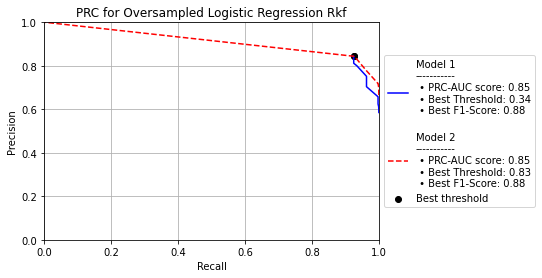

Best Threshold=0.826072, F1-Score=0.882 for model 1
Best Threshold=0.826194, F1-Score=0.882 for model 2


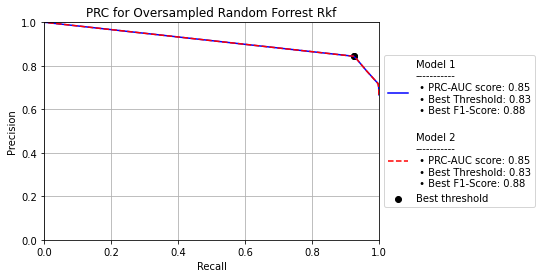

Best Threshold=0.826125, F1-Score=0.882 for model 1
Best Threshold=0.826125, F1-Score=0.882 for model 2


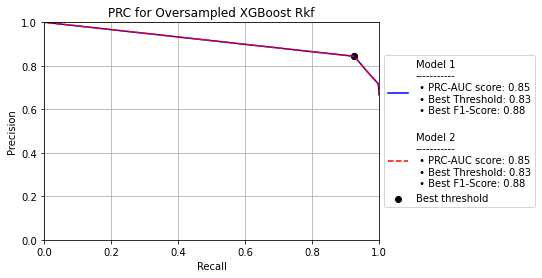

Best Threshold=0.808838, F1-Score=1.000 for model 1
Best Threshold=0.810914, F1-Score=1.000 for model 2


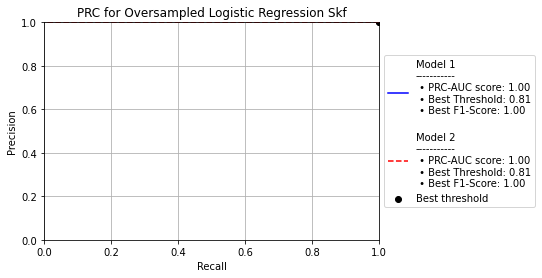

Best Threshold=0.811079, F1-Score=1.000 for model 1
Best Threshold=0.810979, F1-Score=1.000 for model 2


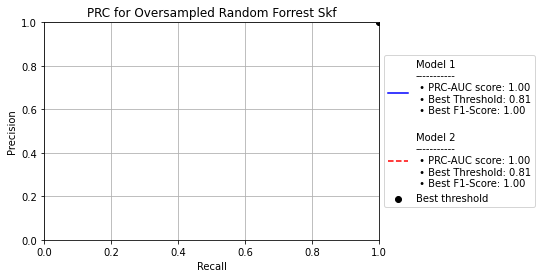

Best Threshold=0.810930, F1-Score=1.000 for model 1
Best Threshold=0.810930, F1-Score=1.000 for model 2


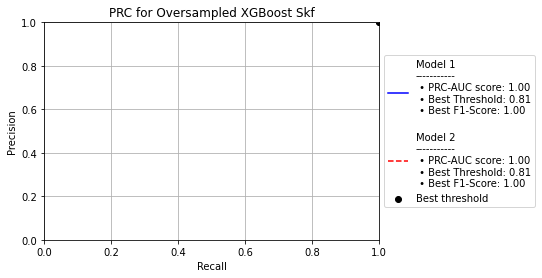

Best Threshold=0.060622, F1-Score=1.000 for model 1
Best Threshold=0.005579, F1-Score=1.000 for model 2


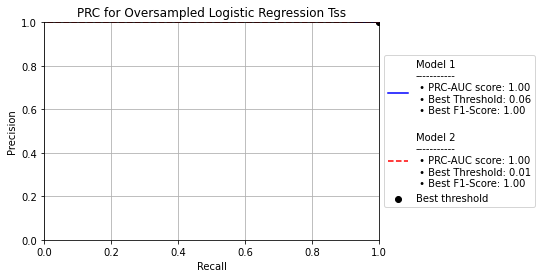

Best Threshold=0.010869, F1-Score=1.000 for model 1
Best Threshold=0.007727, F1-Score=1.000 for model 2


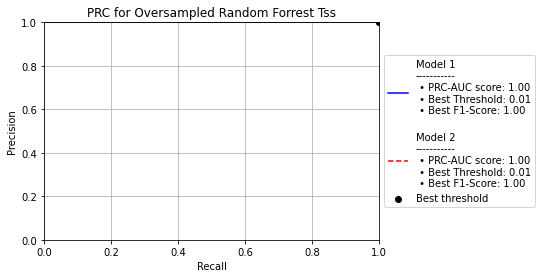

Best Threshold=0.011403, F1-Score=1.000 for model 1
Best Threshold=0.001834, F1-Score=1.000 for model 2


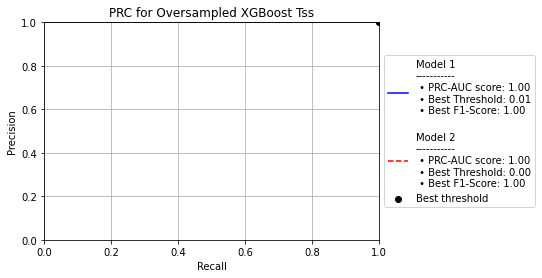

In [62]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Oversampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Oversampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Oversampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Oversampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Oversampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Oversampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Oversampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Oversampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Oversampled XGBoost Tss")

##### Combining Oversampling with Undersampling

In [63]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [64]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(24457, 5)
x2 Before SMOTE:
(24457, 129)
x1 After SMOTE:
(31670, 5)
x2 After SMOTE:
(31670, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [65]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(31670, 5)
x2 Before RandomUnderSampler:
(31670, 129)
x1 After RandomUnderSampler:
(31670, 5)
x2 After RandomUnderSampler:
(31670, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [66]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[54][0] = "OSUS_Combination_Logistic_Regression"
results_data[54][1] = lr_model1.score(x1_test, y1_test)
results_data[54][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[55][0] = "OSUS_Combination_Random_Forrest"
results_data[55][1] = rf_model1.score(x1_test, y1_test)
results_data[55][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[56][0] = "OSUS_Combination_XGB_Classifier"
results_data[56][1] = xgb_model1.score(x1_test, y1_test)
results_data[56][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.8620145247868646
Logistic regression training score for model 2: 0.862856541416693
Random Forrest Classification training score for model 1: 0.862856541416693
Random Forrest Classification training score for model 2: 0.862856541416693
XGB Classifier training score for model 1: 0.862856541416693
XGB Classifier training score for model 2: 0.862856541416693


In [67]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.8803763850627867
Average Precision-Recall Score: 0.8163245296918471
PRC-AUC for model 1: 0.897232355724624
Accuracy: 0.862
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.85      4757
           1       0.83      0.92      0.87      4744

    accuracy                           0.86      9501
   macro avg       0.87      0.86      0.86      9501
weighted avg       0.87      0.86      0.86      9501


Scores for model 2
------------------
Roc_Auc Score: 0.8875186952679304
Average Precision-Recall Score: 0.8202820810212401
PRC-AUC for model 2: 0.8360538358137449
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4757
           1       0.83      0.92      0.87      4744

    accuracy       

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.335144, F1-Score=0.869 for model 1
Best Threshold=0.828309, F1-Score=0.870 for model 2


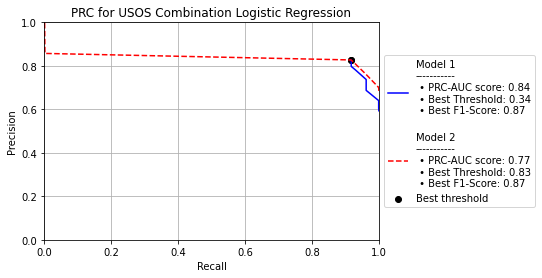

In [68]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.827606, F1-Score=0.870 for model 1
Best Threshold=0.827782, F1-Score=0.870 for model 2


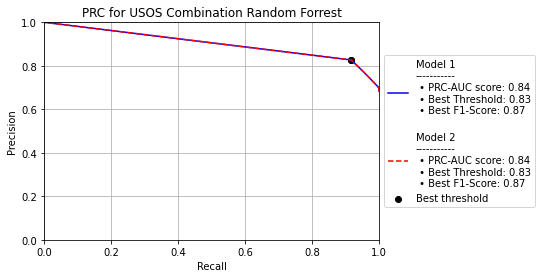

In [69]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.828327, F1-Score=0.870 for model 1
Best Threshold=0.828327, F1-Score=0.870 for model 2


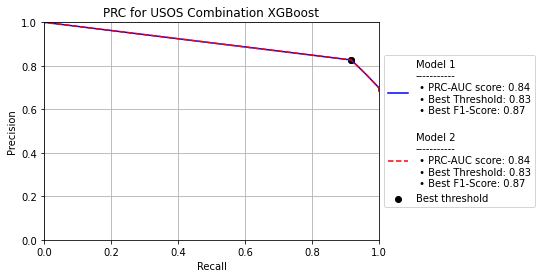

In [70]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

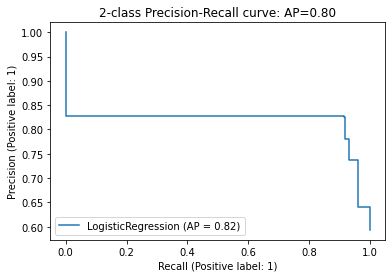

In [71]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

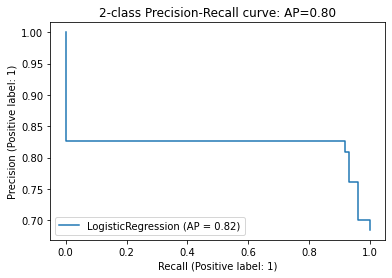

In [72]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [73]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr_model1.score(x1_test, y1_test)
results_data[57][2] = lr_model2.score(x2_test, y2_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf_model1.score(x1_test, y1_test)
results_data[58][2] = rf_model2.score(x2_test, y2_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb_model1.score(x1_test, y1_test)
results_data[59][2] = xgb_model2.score(x2_test, y2_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.8803763850627867
Average Precision-Recall Score: 0.8163245296918471
PRC-AUC for model 1: 0.8377826673286821
Accuracy: 0.862
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.85      4757
           1       0.83      0.92      0.87      4744

    accuracy                           0.86      9501
   macro avg       0.87      0.86      0.86      9501
weighted avg       0.87      0.86      0.86      9501


Scores for model 2
------------------
Roc_Auc Score: 0.8875186952679304
Average Precision-Recall Score: 0.8202820810212401
PRC-AUC for model 2: 0.7725448943017187
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4757
           1       0.83      0.92      0.87      4744

    accuracy                           0.86      9501
   macro avg       0.87      0.86      0.86      9501
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [74]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    1     2     3 ... 31667 31668 31669] | TEST: [    0     4    19 ... 31643 31654 31660]

Model Score: 0.8793811177770761
Average Precision-Recall Score: 0.8228391413698637
PRC-AUC Score: 0.8604433083514763
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1567
           1       0.85      0.93      0.89      1600

    accuracy                           0.88      3167
   macro avg       0.88      0.88      0.88      3167
weighted avg       0.88      0.88      0.88      3167

Accuracy: 0.879
---------------------
With best threshold
TRAIN: [    1     2     3 ... 31667 31668 31669] | TEST: [    0     4    19 ... 31643 31654 31660]

Model Score: 0.8793811177770761
Average Precision-Recall Score: 0.8228391413698637
PRC-AUC Score: 0.8588076266363119
Classification Report:

            

In [75]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[64][1] = model_score
results_data[64][3] = acc
results_data[64][5] = prc_val
results_data[64][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[65][1] = model_score
results_data[65][3] = acc
results_data[65][5] = prc_val
results_data[65][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[66][1] = model_score
results_data[66][3] = acc
results_data[66][5] = prc_val
results_data[66][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[67][1] = model_score
results_data[67][3] = acc
results_data[67][5] = prc_val
results_data[67][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [11086 11087 11088 ... 28499 28500 28501]

Model Score: 0.9665298389643195

Average Precision-Recall Score: 0.9665509691164885
PRC-AUC Score: 0.9343434343434344
Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1583
           1       1.00      0.93      0.97      1584

    accuracy                           0.97      3167
   macro avg       0.97      0.97      0.97      3167
weighted avg       0.97      0.97      0.97      3167

Accuracy: 0.967
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [11086 11087 11088 ... 28499 28500 28501]

Model Score: 0.9665298389643195

Average Precision-Recall Score: 0.9665509691164885
PRC-AUC Score: 0.9321442399788062
Classification Report:

          

In [76]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[68][1] = model_score
results_data[68][3] = acc
results_data[68][5] = prc_val
results_data[68][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[69][1] = model_score
results_data[69][3] = acc
results_data[69][5] = prc_val
results_data[69][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[70][1] = model_score
results_data[70][3] = acc
results_data[70][5] = prc_val
results_data[70][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[71][1] = model_score
results_data[71][3] = acc
results_data[71][5] = prc_val
results_data[71][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 15833 15834 15835] | TEST: [15836 15837 15838 ... 21111 21112 21113]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    5278.0

    accuracy                           0.00    5278.0
   macro avg       0.00      0.00      0.00    5278.0
weighted avg       0.00      0.00      0.00    5278.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 15833 15834 15835] | TEST: [15836 15837 15838 ... 21111 21112 21113]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00  

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [77]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    1     2     3 ... 31667 31668 31669] | TEST: [    0     4    19 ... 31643 31654 31660]

Model Score: 0.8806441427218188
Average Precision-Recall Score: 0.8240178845014697
PRC-AUC Score: 0.8604653088442589
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1567
           1       0.85      0.93      0.89      1600

    accuracy                           0.88      3167
   macro avg       0.88      0.88      0.88      3167
weighted avg       0.88      0.88      0.88      3167

Accuracy: 0.881
---------------------
With best threshold
TRAIN: [    1     2     3 ... 31667 31668 31669] | TEST: [    0     4    19 ... 31643 31654 31660]

Model Score: 0.8806441427218188
Average Precision-Recall Score: 0.8240178845014697
PRC-AUC Score: 0.7530688545942533
Classification Report:

            

In [78]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[64][2] = model_score
results_data[64][4] = acc
results_data[64][6] = prc_val
results_data[64][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[65][2] = model_score
results_data[65][4] = acc
results_data[65][6] = prc_val
results_data[65][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[66][2] = model_score
results_data[66][4] = acc
results_data[66][6] = prc_val
results_data[66][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[67][2] = model_score
results_data[67][4] = acc
results_data[67][6] = prc_val
results_data[67][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 4752  4753  4754 ... 22164 22165 22166]

Model Score: 0.9668455952005052

Average Precision-Recall Score: 0.9668246511671512
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1584
           1       1.00      0.93      0.97      1583

    accuracy                           0.97      3167
   macro avg       0.97      0.97      0.97      3167
weighted avg       0.97      0.97      0.97      3167

Accuracy: 0.967
---------------------
With best threshold
TRAIN: [    0     1     2 ... 31667 31668 31669] | TEST: [ 4752  4753  4754 ... 22164 22165 22166]

Model Score: 0.9668455952005052

Average Precision-Recall Score: 0.9668246511671512
PRC-AUC Score: 0.7502370166441236
Classification Report:

              precision  

In [79]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[68][2] = model_score
results_data[68][4] = acc
results_data[68][6] = prc_val
results_data[68][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[69][2] = model_score
results_data[69][4] = acc
results_data[69][6] = prc_val
results_data[69][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[70][2] = model_score
results_data[70][4] = acc
results_data[70][6] = prc_val
results_data[70][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[71][2] = model_score
results_data[71][4] = acc
results_data[71][6] = prc_val
results_data[71][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 15833 15834 15835] | TEST: [15836 15837 15838 ... 21111 21112 21113]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    5278.0

    accuracy                           0.00    5278.0
   macro avg       0.00      0.00      0.00    5278.0
weighted avg       0.00      0.00      0.00    5278.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 15833 15834 15835] | TEST: [15836 15837 15838 ... 21111 21112 21113]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00  

Best Threshold=0.334253, F1-Score=0.887 for model 1
Best Threshold=0.720635, F1-Score=0.887 for model 2


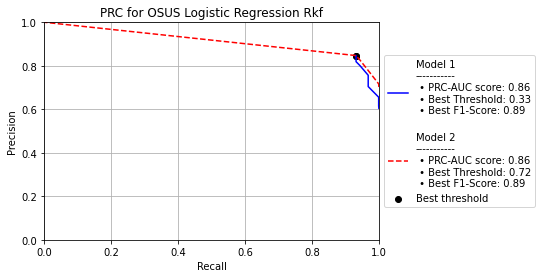

Best Threshold=0.455189, F1-Score=0.887 for model 1
Best Threshold=0.825780, F1-Score=0.887 for model 2


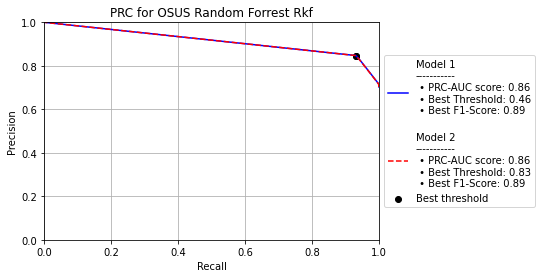

Best Threshold=0.825767, F1-Score=0.887 for model 1
Best Threshold=0.825767, F1-Score=0.887 for model 2


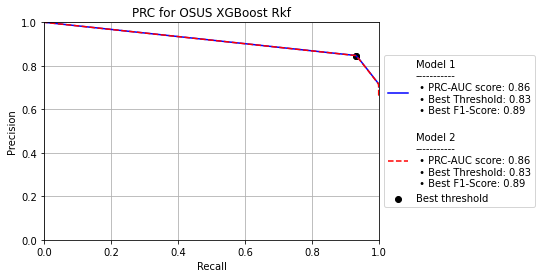

Best Threshold=0.353872, F1-Score=0.966 for model 1
Best Threshold=0.005702, F1-Score=1.000 for model 2


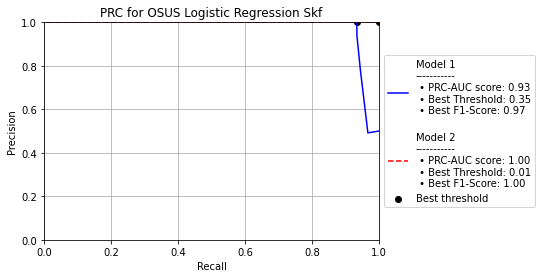

Best Threshold=0.157638, F1-Score=1.000 for model 1
Best Threshold=0.026160, F1-Score=1.000 for model 2


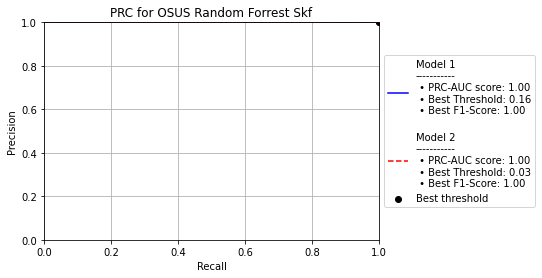

Best Threshold=0.057506, F1-Score=1.000 for model 1
Best Threshold=0.002003, F1-Score=1.000 for model 2


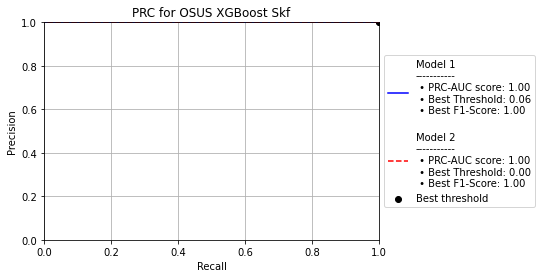

Best Threshold=0.000000, F1-Score=1.000 for model 1
Best Threshold=0.000013, F1-Score=1.000 for model 2


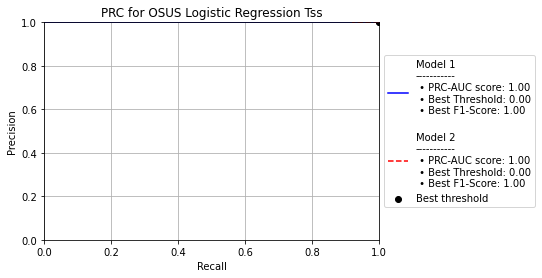

Best Threshold=0.157612, F1-Score=1.000 for model 1
Best Threshold=0.017885, F1-Score=1.000 for model 2


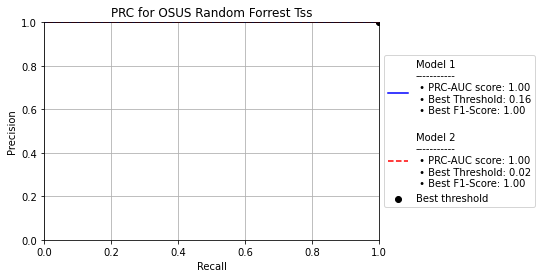

Best Threshold=0.000034, F1-Score=1.000 for model 1
Best Threshold=0.000034, F1-Score=1.000 for model 2


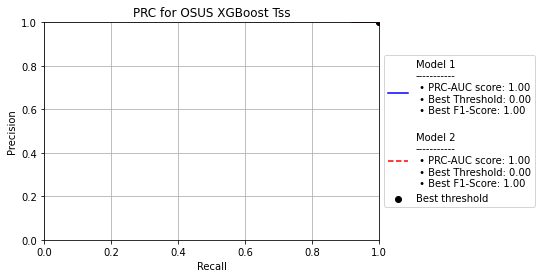

In [80]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "OSUS Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "OSUS Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "OSUS XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "OSUS Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "OSUS Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "OSUS XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "OSUS Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "OSUS Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "OSUS XGBoost Tss")

In [81]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [82]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.854047,0.854729,0.854047,0.854729,0.722787,0.726515,0.847301,0.850667
1,Original_Random_Forrest,0.854729,0.854729,0.854729,0.854729,0.726153,0.726152,0.850490,0.850489
2,Original_XGB_Classifier,0.854729,0.854729,0.854729,0.854729,0.726132,0.726152,0.850471,0.850490
3,Original_Logistic_Regression_Best_Threshold,0.854047,0.854729,0.854456,0.854729,0.722787,0.726515,0.799480,0.800050
4,Original_Random_Forrest_Best_Threshold,0.854729,0.854729,0.854729,0.854729,0.726153,0.726152,0.799897,0.799897
...,...,...,...,...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.966846,0.966846,0.966846,0.966846,0.966825,0.966825,1.000000,1.000000
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.966846,0.966846,0.966846,0.966846,0.966825,0.966825,1.000000,1.000000


In [83]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.854047,0.854047,0.722787,0.847301
1,Original_Random_Forrest,0.854729,0.854729,0.726153,0.850490
2,Original_XGB_Classifier,0.854729,0.854729,0.726132,0.850471
3,Original_Logistic_Regression_Best_Threshold,0.854047,0.854456,0.722787,0.799480
4,Original_Random_Forrest_Best_Threshold,0.854729,0.854729,0.726153,0.799897
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.966846,0.966846,0.966825,1.000000
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.966846,0.966846,0.966825,1.000000


In [84]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.854729,0.854729,0.726515,0.850667
1,Original_Random_Forrest,0.854729,0.854729,0.726152,0.850489
2,Original_XGB_Classifier,0.854729,0.854729,0.726152,0.850490
3,Original_Logistic_Regression_Best_Threshold,0.854729,0.854729,0.726515,0.800050
4,Original_Random_Forrest_Best_Threshold,0.854729,0.854729,0.726152,0.799897
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.966846,0.966846,0.966825,1.000000
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.966846,0.966846,0.966825,1.000000


In [85]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
10,Original_Logistic_Regression_skf,1.000000,1.000000,1.000000,1.000000
12,Original_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
13,Original_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
46,Oversampled_Logistic_Regression_skf,1.000000,1.000000,1.000000,1.000000
48,Oversampled_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
49,Oversampled_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
66,OSUS_Combination_Random_Forrest_skf,0.966846,0.966846,0.966825,1.000000
67,OSUS_Combination_XGB_Classifier_skf,0.966846,0.966846,0.966825,1.000000
64,OSUS_Combination_Logistic_Regression_skf,0.966530,0.966530,0.966551,0.934343
65,OSUS_Combination_Logistic_Regression_skf_Best_...,0.966530,0.966530,0.966551,0.932144


In [86]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
67,OSUS_Combination_XGB_Classifier_skf,0.966846,0.966846,0.966825,1.000000
66,OSUS_Combination_Random_Forrest_skf,0.966846,0.966846,0.966825,1.000000
64,OSUS_Combination_Logistic_Regression_skf,0.966846,0.966846,0.966825,1.000000
49,Oversampled_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
48,Oversampled_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
46,Oversampled_Logistic_Regression_skf,1.000000,1.000000,1.000000,1.000000
10,Original_Logistic_Regression_skf,1.000000,1.000000,1.000000,1.000000
12,Original_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
13,Original_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
56,OSUS_Combination_XGB_Classifier,0.862857,0.862857,0.820253,0.901355


In [88]:
figures = [lr_skf_osus_fig, rf_skf_osus_fig, xgb_skf_osus_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/Ivy/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')

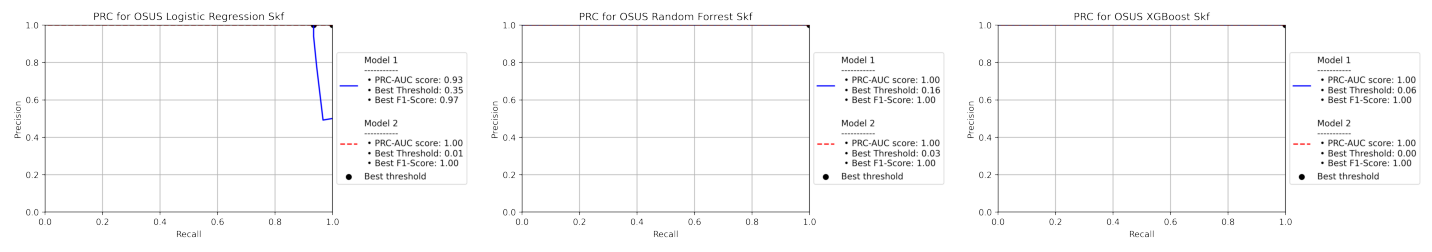

In [89]:
img_A = mpimg.imread('../../img/Ivy/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/Ivy/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/Ivy/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/Ivy/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')